In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("dark_background")

import warnings
warnings.filterwarnings("ignore")

In [2]:
dataset = "./Perrin Freres monthly champagne sales millions.csv"

In [3]:
data = pd.read_csv(dataset)
data.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 2 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Month                                                   106 non-null    object 
 1   Perrin Freres monthly champagne sales millions ?64-?72  105 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.8+ KB


In [5]:
data.isnull().sum()

Month                                                     1
Perrin Freres monthly champagne sales millions ?64-?72    2
dtype: int64

In [6]:
data.shape

(107, 2)

# Data Pre-processing and basic EDA
    Renaming the Sales column to AvgSales as the original names was hard to infer
    Dropping the NaN values as we have 1 in Month and 2 in Sales columns respectively
    Changing the format of Month column from object to Datetime

In [7]:
data.columns = ["Month", "AvgSales"]
data = data.dropna()
data["Month"] = pd.to_datetime(data["Month"])

In [8]:
data.columns

Index(['Month', 'AvgSales'], dtype='object')

In [9]:
data.isnull().sum()

Month       0
AvgSales    0
dtype: int64

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Month     105 non-null    datetime64[ns]
 1   AvgSales  105 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.5 KB


In [11]:
data.describe()

,AvgSales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


In [12]:
data.set_index("Month", inplace=True)

# Data Visualization

<AxesSubplot:xlabel='AvgSales', ylabel='Count'>

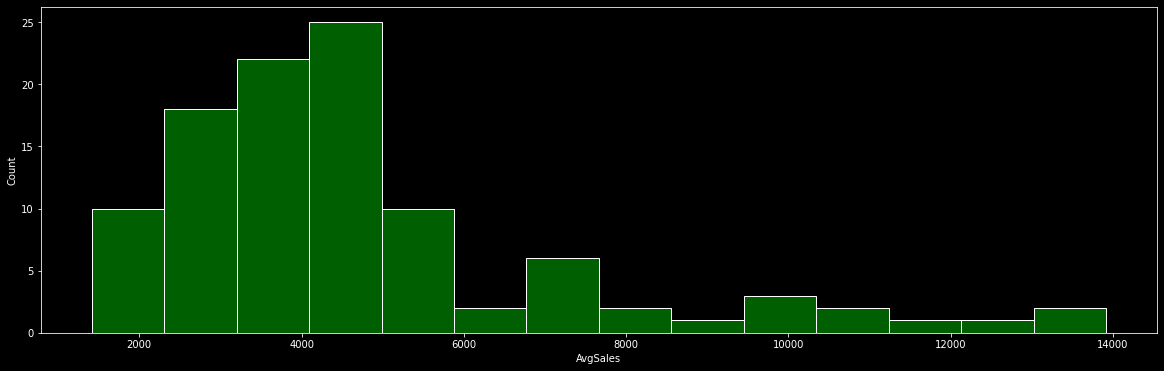

In [13]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.histplot(data["AvgSales"], ax=ax, color="green")

Text(0, 0.5, 'Sales in Million (USD)')

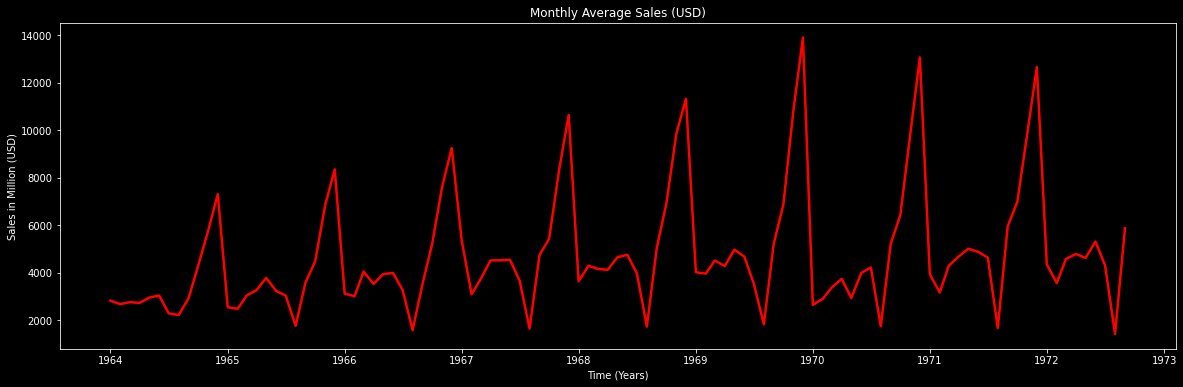

In [14]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.lineplot(data.index, data["AvgSales"], ax=ax, color="red", linewidth=2.5)
ax.set_title("Monthly Average Sales (USD)")
ax.set_xlabel("Time (Years)")
ax.set_ylabel("Sales in Million (USD)")

From the above plot, we can observe that the sales vary according to seasons. This makes our data seasonal and hence it might not be stationary.
We can check for stationary of our data using Dickey Fuller Test.

In [15]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(sales):
    result = adfuller(sales)
    labels = ["Test statistics: ", "p-value: ", "Number of Lags used: ", "Number of observations used: "]
    for value, label in zip(result, labels):
        print(f"{label}{str(value)}")
    if result[1] <= 0.05:
        print("Data is stationary")
    else:
        print("Data is NOT stationary. ")

In [16]:
adfuller_test(data['AvgSales'])

Test statistics: -1.8335930563276175
p-value: 0.3639157716602477
Number of Lags used: 11
Number of observations used: 93
Data is NOT stationary. 


Here we can observe that the p-value is greater than 0.05 which makes our data NON-Stationary.
To make our data stationary, we difference the data taking in to account of the seasonal factor.

In our case, the seasonal factor will be 12 as the data follows a yearly seasonal effect. 
Let's difference our data with the above mentioned shift factor and save it in a new column "First_Difference".

In [17]:
data["First_Difference"] = data["AvgSales"] - data["AvgSales"].shift(12)
data

,AvgSales,First_Difference
Month,,
1964-01-01,2815.0,NaN
1964-02-01,2672.0,NaN
1964-03-01,2755.0,NaN
1964-04-01,2721.0,NaN
1964-05-01,2946.0,NaN
...,...,...
1972-05-01,4618.0,-392.0
1972-06-01,5312.0,438.0
1972-07-01,4298.0,-335.0


Now applying the Dickey Fuller Test again to test for the stationarity of the data.

In [18]:
adfuller_test(data['First_Difference'].dropna())

Test statistics: -7.626619157213164
p-value: 2.060579696813685e-11
Number of Lags used: 0
Number of observations used: 92
Data is stationary


In [19]:
data = data.dropna()
data.head()

,AvgSales,First_Difference
Month,,
1965-01-01,2541.0,-274.0
1965-02-01,2475.0,-197.0
1965-03-01,3031.0,276.0
1965-04-01,3266.0,545.0
1965-05-01,3776.0,830.0


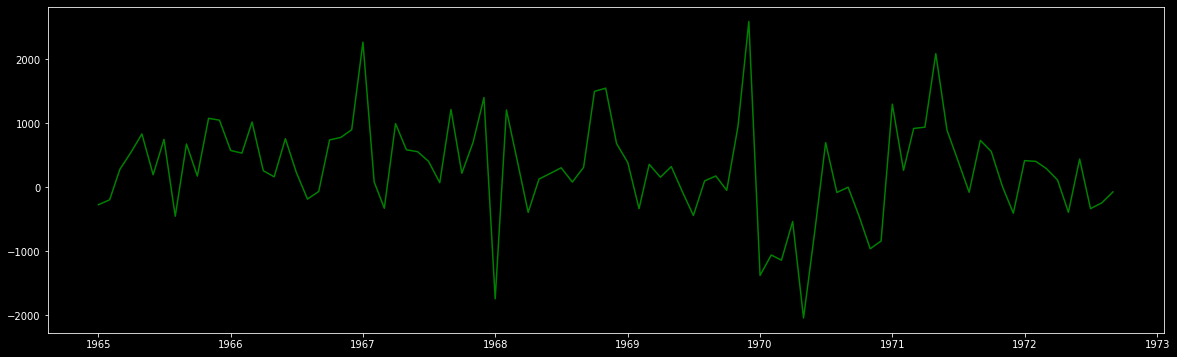

In [20]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(data["First_Difference"], color="green")

Now our "First_Difference" column data looks more stationary and it is backed by the p-value that we got from the Dickey Fuller Test which is much lesser than 0.05.

Let's look at the Auto Correlation and Partial Auto Correlation functions to decide up on the p, d and q values for our model.

Auto Correlation Function (ACF) is more suitable for Moving Average (MA) model -- q value

Partial Correlation Function (PACF) is more suitable for Auto Regressive (AR) model -- p value


ACF and PACF are used to find the best lag values for MA and AR models respectively.

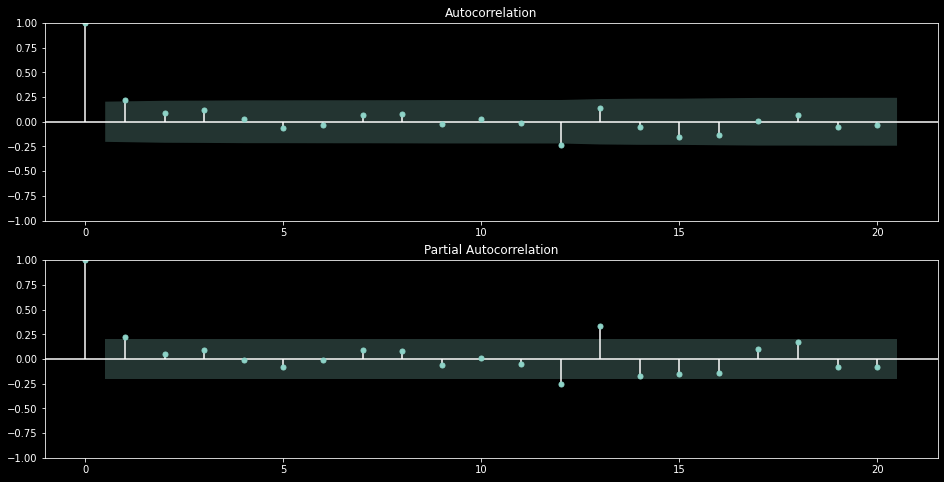

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(data["First_Difference"], ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(data["First_Difference"], ax=ax2)

In [22]:
# setting the hyper parameters
p = 1 # As abrupt decrease happens in 1
d = 1 # No. of differences we took ==> 1
q = 1 # Considering q to be 1

# ARIMA Model

In [23]:
from statsmodels.tsa.arima.model import ARIMA

arima = ARIMA(data["AvgSales"], order=(p, d, q))
model = arima.fit()
model.summary()

C:\Users\SriHema\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\SriHema\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\SriHema\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               AvgSales   No. Observations:                   93
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -846.679
Date:                Mon, 09 May 2022   AIC                           1699.358
Time:                        16:57:30   BIC                           1706.924
Sample:                    01-01-1965   HQIC                          1702.412
                         - 09-01-1972                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4711      0.050      9.480      0.000       0.374       0.568
ma.L1         -0.9995      0.133     -7.530      0.000      -1.260      -0.739
sigma2      5.559e+06   2.44e-08   2.27e+14      0.000    5.56e+06    5.56e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.60   Jarque-Bera (JB):                 1.48
Prob(Q):                              0.44   Prob(JB):                         0.48
Heteroskedasticity (H):               2.56   Skew:                             0.05
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.42e+30. Standard errors may be unstable.
"""

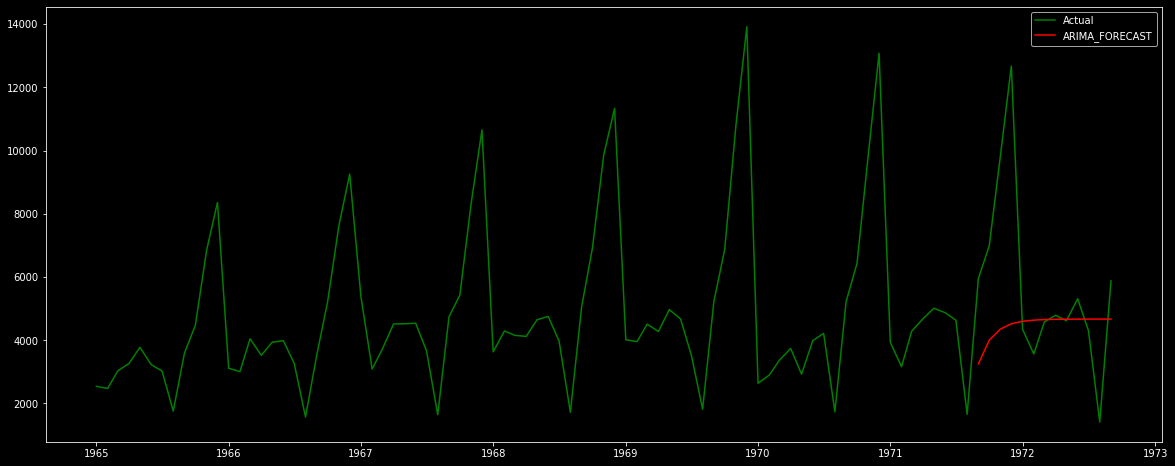

In [24]:
data["arima_forecast"] = model.predict(start=80, end=103, dynamic=True)
plt.figure(figsize=(20, 8))
plt.plot(data.AvgSales, c="green", label="Actual")
plt.plot(data.arima_forecast, c="red", label="ARIMA_FORECAST")
plt.legend(loc="best")
plt.show()

As the data is seasonal, we can see that ARIMA did not perform well. Let's try with SARIMAX (Seasonal - ARIMA) model.

In [25]:
import statsmodels.api as sm

sarima = sm.tsa.statespace.SARIMAX(data["AvgSales"].dropna(), 
                                    order=(1, 1, 1),
                                    seasonal_order=(1, 1, 1, 12))
results = sarima.fit()
results.summary()

C:\Users\SriHema\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\SriHema\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           AvgSales   No. Observations:                   93
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -645.666
Date:                            Mon, 09 May 2022   AIC                           1301.331
Time:                                    16:57:33   BIC                           1313.241
Sample:                                01-01-1965   HQIC                          1306.106
                                     - 09-01-1972                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3910      0.100      3.916      0.000       0.195       0.587
ma.L1         -0.9254      0.060    -15.533      0.000      -1.042      -0.809
ar.S.L12      -0.9558      0.169     -5.641      0.000      -1.288      -0.624
ma.S.L12       0.8367      0.350      2.390      0.017       0.151       1.523
sigma2        5.4e+05   1.05e+05      5.141      0.000    3.34e+05    7.46e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):                 1.33
Prob(Q):                              0.56   Prob(JB):                         0.51
Heteroskedasticity (H):               0.58   Skew:                            -0.20
Prob(H) (two-sided):                  0.16   Kurtosis:                         3.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

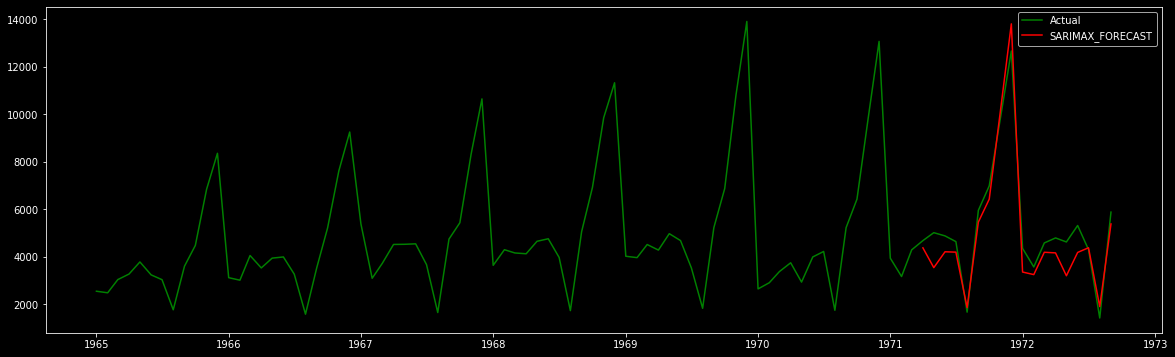

In [26]:
data["sarima_forecast"] = results.predict(start=75, end=104, dynamic=True)
plt.figure(figsize=(20, 6))
plt.plot(data.AvgSales, c="green", label="Actual")
plt.plot(data.sarima_forecast, c="red", label="SARIMAX_FORECAST")
plt.legend(loc="best")
plt.show()

Sales Forecasting for future data

In [27]:
from pandas.tseries.offsets import DateOffset
forecast_dates = [data.index[-1] + DateOffset(months = x) for x in range(0, 24)]
forecast_dataset = pd.DataFrame(index = forecast_dates[1:], columns = data.columns)
merged = pd.concat([data, forecast_dataset])
merged.tail()

,AvgSales,First_Difference,arima_forecast,sarima_forecast
1974-04-01,NaN,NaN,NaN,NaN
1974-05-01,NaN,NaN,NaN,NaN
1974-06-01,NaN,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN,NaN
1974-08-01,NaN,NaN,NaN,NaN


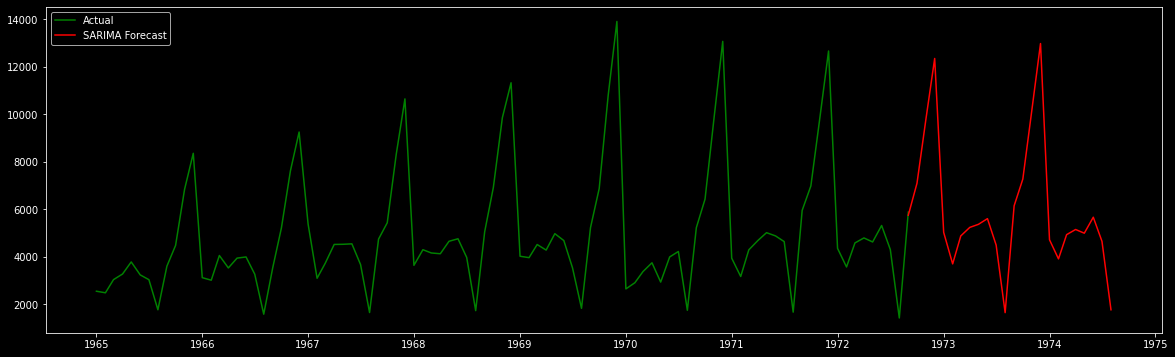

In [28]:
merged['sarima_forecast'] = results.predict(start=92, end=120, dynamic=True)
plt.figure(figsize=(20, 6))
plt.plot(merged["AvgSales"], color="green", label="Actual")
plt.plot(merged["sarima_forecast"], color="red", label="SARIMA Forecast")
plt.legend(loc="best")
plt.show()